<center>

<table><tr><td><img src='./img/sber.jpg' width='450'></td><td><img src='./img/ods.jpg' width='400'></td></tr></table>

</center>


<center>
    
# Анализ временных рядов на примере прогнозирования спроса наличности в банкоматах

**Авторы материала:** Дмитрий Сергеев, Денис Димитров. Материал можно использовать в любых целях (редактировать, поправлять и брать за основу), но с обязательным упоминанием авторов материала.

## Познакомимся

Здравствуйте, меня зовут Димитров Денис. Я Senior Data Scientist в отделе CDS ПАО Сбербанк.

Курс, который я буду рассказывать, посвящен прогнозированию временных рядов в целом, прогнозировнию спроса наличности в банкоматах в частности, а также дальнейшей оптимизации инкассаторских поездок, основанной на получившемся прогнозе.

## <center>Часть 1. Введение. Общие методы прогнозирования временных рядов</center>

# План:

1. Скользящие статистики
    - Rolling window estimations
    - Экспоненциальное сглаживание, модель Хольта-Винтерса
    - Кросс-валидация на временных рядах, подбор параметров
2. Методы машинного обучения для прогноза временных рядов
    - Извлечение признаков (Feature extraction)
    - Линейная регрессия vs XGBoost

На работе я практически ежедневно сталкиваюсь с задачами, связанными с временными рядам. Чаще всего возникает вопрос - а что будет происходить с теми или иными показателями в ближайший день/неделю/месяц/пр. - какой спрос на наличность будет в каждом конкретном банкомате на завтра, сколько человек придет в отделение банка в ближайшую неделю итд. К задаче прогнозирования можно подходить по-разному, в зависимости от того, какого качества должен быть прогноз, на какой период мы хотим его строить, и, конечно, как долго по времени есть возможность подбирать и настраивать параметры модели для его получения. 

Начнем с простых методов анализа и прогнозирования - скользящих средних, сглаживаний и их вариаций.

# Скользящие статистики

Небольшое [определение](https://ru\.wikipedia.org/wiki/Временной_ряд) временного ряда:
> Временной ряд – это последовательность значений, описывающих протекающий во времени процесс, измеренных в последовательные моменты времени, обычно через равные промежутки

Таким образом, данные оказываются упорядочены относительно неслучайных моментов времени, и, значит, в отличие от случайных выборок, могут содержать в себе дополнительную информацию, которую мы постараемся извлечь. 

In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from copy import deepcopy

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
#from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline


from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
init_notebook_mode(connected = True)

def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

In [2]:
# кусок, который скрывает весь код, оставляя вывод (вдруг кому-то пригодится)
# from IPython.display  import HTML

# HTML('''<script>
# code_show=true;
# function code_toggle() {
#     if (code_show){
#     $('div.input').hide();
#     } else {
#     $ ('div.input').show();
#     }
#     code_show = !code_show
#     }
#     $( document ).ready(code_toggle);
#     </script>
#     <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

Пока возьмем хороший ряд, который можно предсказать скользящими методами (количество игроков в онлайне одной из мобильных игр)

In [3]:
dataset = pd.read_csv('./data/lecture1/hour_online.csv', index_col=['Time'], parse_dates=['Time'])
plotly_df(dataset, title = "Online users")

Начнем моделирование с наивного предположения - "завтра будет, как вчера", но вместо модели вида $\widehat{y}_{t} = y_{t-1}$ будем считать, что будущее значение переменной зависит от среднего $n$ её предыдущих значений, а значит, воспользуемся скользящей средней. 

$\widehat{y}_{t} = \frac{1}{n} \displaystyle\sum_{k=1}^{n} y_{t-k}$

In [4]:
def moving_average(series, n):
    return np.average(series[-n:])

moving_average(dataset.Users, 24) # посмотрим на прогноз, построенный по последнему наблюдаемому дню (24 часа)

29858.333333333332

In [5]:
plotly_df(dataset[-24:])

К сожалению, такой прогноз долгосрочным сделать не удастся, для получения предсказания на шаг вперед предыдущее значение должно быть фактически наблюдаемой величиной. Зато у скользящей средней есть другое применение - сглаживание исходного ряда для выявления трендов, в пандасе есть готовая реализация - [`DataFrame.rolling(window).mean()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html). Чем больше зададим ширину интервала - тем более сглаженным окажется тренд. В случае, если данные сильно зашумлены, что особенно часто встречается, например, в финансовых показателях, такая процедура может помочь увидеть общие паттерны.

In [6]:
def plotMovingAverage(series, n):
    
    """
    series - dataframe with timeseries
    n - rolling window size 
    
    """
    
    rolling_mean = series.rolling(window=n).mean().shift(1)
    
    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std().shift(1)
    upper_bond = rolling_mean+1.96*rolling_std
    lower_bond = rolling_mean-1.96*rolling_std
    
    
    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")
    
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(series[n+1:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

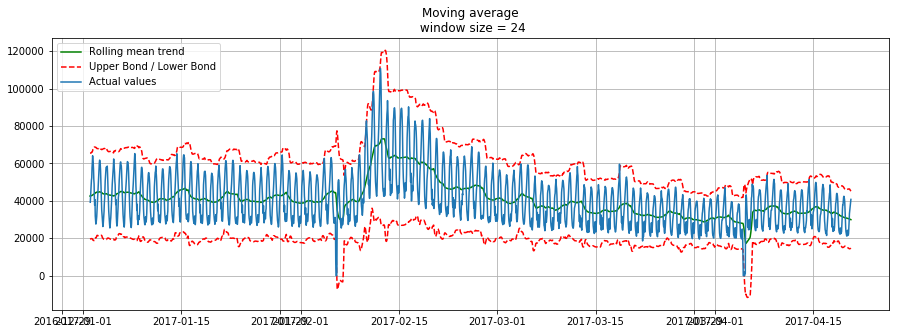

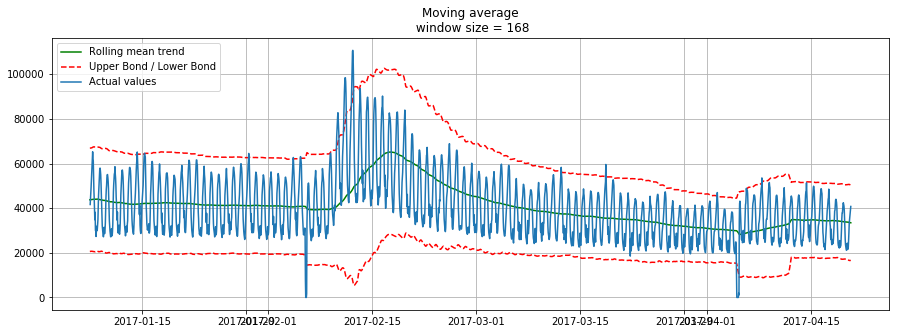

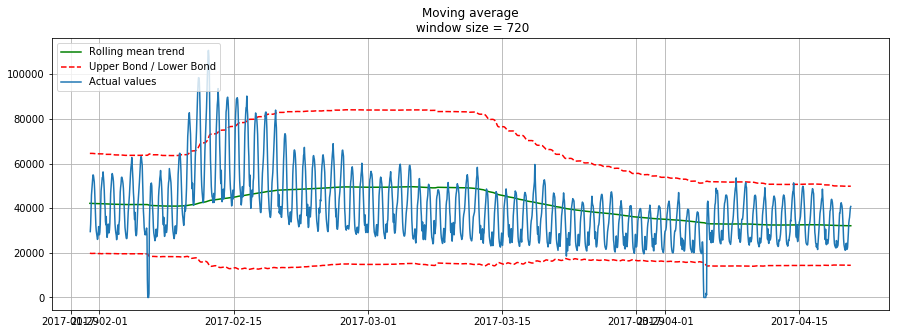

In [7]:
plotMovingAverage(dataset, 24) # сглаживаем по дням
plotMovingAverage(dataset, 24*7) # сглаживаем по неделям
plotMovingAverage(dataset, 24*30) # сглаживаем по месяцам

Для нашего ряда тренды и так вполне очевидны, но если сгладить по дням, становится лучше видна динамика онлайна по будням и выходным (выходные - время поиграть), а недельное сглаживание хорошо отражает общие изменения, связанные с резким ростом числа активных игроков в феврале и последующим снижением в марте.

Модификацией простой скользящей средней является взвешенная средняя, внутри которой наблюдениям придаются различные веса, в сумме дающие единицу, при этом обычно последним наблюдениям присваивается больший вес. 


$\widehat{y}_{t} = \displaystyle\sum_{k=1}^n \omega_k y_{t-k}$

In [8]:
dataset.Users[-5:]

Time
2017-04-20 05:00:00    34833
2017-04-20 06:00:00    35932
2017-04-20 07:00:00    38418
2017-04-20 08:00:00    40238
2017-04-20 09:00:00    40763
Name: Users, dtype: int64

In [9]:
np.average(dataset.Users[-5:], weights=[0.03, 0.07, 0.1, 0.2, 0.6])

39907.43

In [10]:
dataset.Users[-5:]

Time
2017-04-20 05:00:00    34833
2017-04-20 06:00:00    35932
2017-04-20 07:00:00    38418
2017-04-20 08:00:00    40238
2017-04-20 09:00:00    40763
Name: Users, dtype: int64

In [11]:
plotly_df(dataset[-5:])

## Экспоненциальное сглаживание

А теперь посмотрим, что произойдёт, если вместо взвешивания последних $n$ значений ряда мы начнем взвешивать все доступные наблюдения, при этом экспоненциально уменьшая веса по мере углубления в исторические данные. В этом нам поможет формула простого [экспоненциального сглаживания](http://www.machinelearning.ru/wiki/index.php?title=Экспоненциальное_сглаживание):

$${\ell}_{t} = \alpha \cdot y_t + (1-\alpha) \cdot {\ell}_{t-1}$$
$$\ell_0 = y_0$$

Тогда прогноз будет строиться следующим образом:
$$\widehat{y}_{t+1} = {\ell}_t$$

Здесь модельное значение представляет собой средневзвешенную между текущим истинным и предыдущим модельным значениями. Вес $\alpha$ называется сглаживающим фактором. Он определяет, как быстро мы будем "забывать" последнее доступное истинное наблюдение. Чем меньше $\alpha$, тем больше влияния оказывают предыдущие модельные значения, и тем сильнее сглаживается ряд. 

Экспоненциальность скрывается в рекурсивности функции - каждый раз мы умножаем $(1-\alpha)$ на предыдущее модельное значение, которое, в свою очередь, также содержало в себе $(1-\alpha)$, и так до самого начала.

In [12]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)-1):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return [np.nan]+result

In [13]:
alpha1 = 0.3
alpha2 = 0.05
df = pd.concat([dataset,
                pd.DataFrame(exponential_smoothing(dataset.Users, alpha1), index=dataset.index), 
                pd.DataFrame(exponential_smoothing(dataset.Users, alpha2), index=dataset.index)], axis=1)
df.columns=['Actual', 'Alpha = ' + str(alpha1), 'Alpha = ' + str(alpha2)]

In [14]:
plotly_df(df, title = "Exponential Smooting")

## Двойное экспоненциальное сглаживание

До сих пор мы могли получить от наших методов в лучшем случае прогноз лишь на одну точку вперёд (и ещё красиво сгладить ряд), это здорово, но недостаточно, поэтому переходим к расширению экспоненциального сглаживания, которое позволит строить прогноз сразу на несколько точек вперед (и тоже красиво сглаживать ряд).

В этом нам поможет разбиение ряда на две составляющие - уровень (level, intercept) $\ell$ и тренд $b$ (trend, slope). Уровень, или ожидаемое значение ряда, мы предсказывали при помощи предыдущих методов, а теперь такое же экспоненциальное сглаживание применим к тренду, наивно или не очень полагая, что будущее направление изменения ряда зависит от взвешенных предыдущих изменений.

$\ell_t = \alpha y_t + (1-\alpha)(\ell_{t-1} + b_{t-1})$

$b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

$\widehat{y}_{t+m} = \ell_t + m \cdot b_t$

В результате получаем набор функций. Первая описывает уровень - он, как и прежде, зависит от текущего значения ряда, а второе слагаемое теперь разбивается на предыдущее значение уровня и тренда. Вторая отвечает за тренд - он зависит от изменения уровня на текущем шаге, и от предыдущего значения тренда. Здесь в роли веса в экспоненциальном сглаживании выступает коэффициент $\beta$. Наконец, итоговое предсказание представляет собой сумму модельных значений уровня и тренда.

In [15]:
def double_exponential_smoothing(series, alpha, beta):
    level, trend = series[0], 0
    result = [level + trend]
#     level, trend = alpha*series[1] + (1-alpha)*(level+trend), series[1]-series[0] # можно по-другому
#     result.append(level+trend)
    for n in range(1, len(series)-1):
        last_level, level = level, alpha*series[n] + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append((level+trend) if level+trend >= 0 else 0)
    return [np.nan]+result

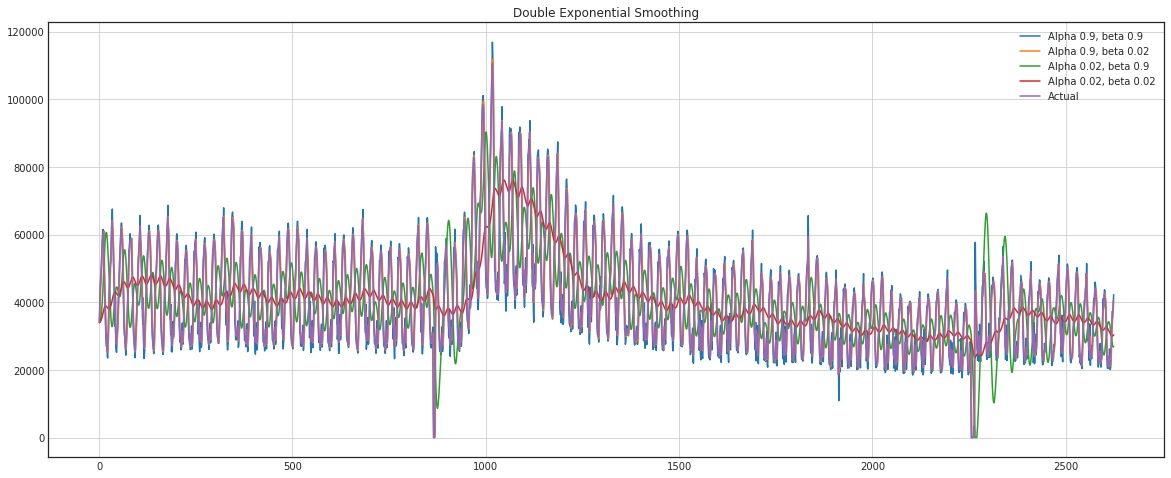

In [16]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Users, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Users.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

Теперь настраивать пришлось уже два параметра - $\alpha$ и $\beta$. Первый отвечает за сглаживание ряда вокруг тренда, второй - за сглаживание самого тренда. Чем выше значения, тем больший вес будет отдаваться последним наблюдениям и тем менее сглаженным окажется модельный ряд. Комбинации параметров могут выдавать достаточно причудливые результаты, особенно если задавать их руками. А о не ручном подборе параметров расскажу чуть ниже, сразу после тройного экспоненциального сглаживания.

Теперь возьмем какой-нибудь банкомат и поисследуем его

In [17]:
import pandas as pd
import numpy as np

In [18]:
all_data=pd.read_csv('./data/lecture1/atm_data_train.csv', index_col=0, parse_dates=True)
all_data.index=pd.to_datetime(all_data.index)

In [19]:
timeseries=all_data[all_data.ATM_ID==409605]['Клиентский расход']

In [20]:
df = pd.concat([pd.DataFrame(timeseries),
                pd.DataFrame(exponential_smoothing(timeseries, 0.4), index=timeseries.index),
                pd.DataFrame(double_exponential_smoothing(timeseries, 0.4, 0.8), index=timeseries.index)], axis=1)
df.columns=['Actual', 'Smoothing', 'Double Smoothing']

In [21]:
plotly_df(df, title='Сравнение двух методов')

Теперь посчитаем ошибку прогноза

$MAE = \frac{1}{k} \sum_{i=1}^k |y_i - \hat{y}_i|$  

$MSE = \frac{1}{2k} \sum_{i=1}^k (y_i - \hat{y}_i)^2$  

In [22]:
roll_days=10
mae_smooting=np.abs(df['Actual']-df['Smoothing']).rolling(roll_days).mean().dropna()
mae_double_smooting=np.abs(df['Actual']-df['Double Smoothing']).rolling(roll_days).mean().dropna()

In [23]:
df_mae = pd.concat([mae_smooting, mae_double_smooting], axis=1)
df_mae.columns = ['MAE_SMOTHING', 'MAE_DOUBLE_SMOOTING']
plotly_df(df_mae, title='Скользящее MAE')

Для онлайн-игры

In [24]:
df = pd.concat([pd.DataFrame(dataset.Users),
                pd.DataFrame(exponential_smoothing(dataset.Users, 0.6), index=dataset.Users.index),
                pd.DataFrame(double_exponential_smoothing(dataset.Users, 0.6, 0.2), index=dataset.Users.index)], axis=1)
df.columns=['Actual', 'Smoothing', 'Double Smoothing']

In [25]:
plotly_df(df, title='Сравнение двух методов')

In [26]:
roll_days=10
mae_smooting=np.abs(df['Actual']-df['Smoothing']).rolling(roll_days).mean().dropna()
mae_double_smooting=np.abs(df['Actual']-df['Double Smoothing']).rolling(roll_days).mean().dropna()

In [27]:
df_mae = pd.concat([mae_smooting, mae_double_smooting], axis=1)
df_mae.columns = ['MAE_SMOTHING', 'MAE_DOUBLE_SMOOTING']
plotly_df(df_mae, title='Скользящее MAE')

Видно, что все не очень хорошо. Поэтому обратимся к тройному экспоненциальному сглаживанию

## Тройное экспоненциальное сглаживание (известное также как модель Хольта-Винтерса)

Итак, успешно добрались до следующего варианта экспоненциального сглаживания, на этот раз тройного.

Идея этого метода заключается в добавлении еще одной, третьей, компоненты - сезонности. Соответственно, метод применим только в случае, если ряд этой сезонностью не обделён, что в нашем случае верно. Сезонная компонента в модели будет объяснять повторяющиеся колебания вокруг уровня и тренда, а характеризоваться она будет длиной сезона - периодом, после которого начинаются повторения колебаний. Для каждого наблюдения в сезоне формируется своя компонента, например, если длина сезона составляет 7 (например, недельная сезонность), то получим 7 сезонных компонент, по штуке на каждый из дней недели.

Получаем новую систему:

$\ell_t = \alpha(y_t - s_{t-L}) + (1-\alpha)(\ell_{t-1} + b_{t-1})$


$b_t = \beta(\ell_t - \ell_{t-1}) + (1-\beta)b_{t-1}$

$s_t = \gamma(y_t - \ell_t) + (1-\gamma)s_{t-L}$

$\widehat{y}_{t+m} = \ell_t + m \cdot b_t + s_{t-L+1+(m-1)modL}$

Уровень теперь зависит от текущего значения ряда за вычетом соответствующей сезонной компоненты, тренд остаётся без изменений, а сезонная компонента зависит от текущего значения ряда за вычетом уровня и от предыдущего значения компоненты. При этом компоненты сглаживаются через все доступные сезоны, например, если это компонента, отвечающая за понедельник, от и усредняться она будет только с другими понедельниками. Подробнее про работу усреднений и оценку начальных значений тренда и сезонных компонент можно почитать [здесь](http://www.itl.nist.gov/div898/handbook/pmc/section4/pmc435.htm). Теперь, имея сезонную компоненту, мы можем предсказывать уже не на один, и даже не на два, а на произвольные $m$ шагов вперёд, что не может не радовать. 

Ниже приведен код для построения модели тройного экспоненциального сглаживания, также известного по фамилиям её создателей - Чарльза Хольта и его студента Питера Винтерса. 
Дополнительно в модель включен метод Брутлага для построения доверительных интервалов:

$\widehat{y}_{max_t}=\ell_{t−1}+b_{t−1}+s_{t−L}+k⋅d_{t−L}$

$\widehat{y}_{min_t}=\ell_{t−1}+b_{t−1}+s_{t−L}-k⋅d_{t−L}$

$d_t=\gamma∣y_t−\widehat y_t∣+(1−\gamma)d_{t−L}$,

где $L$ - длина сезона, $d$ - предсказанное отклонение, а остальные параметры берутся из тройного сглаживания. Подробнее о методе и о его применении к поиску аномалий во временных рядах можно прочесть [здесь](https://fedcsis.org/proceedings/2012/pliks/118.pdf)

In [28]:
class HoltWinters:
    
    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf
    
    
    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        summ = 0.0
        for i in range(self.slen):
            summ += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return summ / self.slen
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                
                
                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                
            
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])


            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])
                
                
                
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])    

## Кросс-валидация на временных рядах

Перед тем, как построить модель, поговорим, наконец, о не ручной оценке параметров для моделей. 

Ничего необычного здесь нет, по-прежнему сначала необходимо выбрать подходящую для данной задачи функцию потерь: [RMSE](https://en.wikipedia.org/wiki/Root-mean-square_deviation), [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error), [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) и др., которая будет следить за качеством подгонки модели под исходные данные. Затем будем оценивать на кросс-валидации значение функции потерь при данных параметрах модели, искать градиент, менять в соответствии с ним параметры и опускаться в сторону глобального минимума ошибки. 

Небольшая загвоздка возникает только в кросс-валидации. Проблема состоит в том, что временной ряд имеет временную структуру, и случайно перемешивать в фолдах значения всего ряда без сохранения этой структуры нельзя, иначе в процессе потеряются все взаимосвязи наблюдений друг с другом. Поэтому придется использовать чуть более хитрый способ для оптимизации параметров, официального названия которому я так и не нашел, но на сайте [CrossValidated](https://stats.stackexchange.com/questions/14099/using-k-fold-cross-validation-for-time-series-model-selection) предлагают название "cross-validation on a rolling basis", что не дословно можно перевести как кросс-валидация на скользящем окне.

Суть достаточно проста - начинаем обучать модель на небольшом отрезке временного ряда, от начала до некоторого $t$, делаем прогноз на $t+n$ шагов вперед и считаем ошибку. Далее расширяем обучающую выборку до $t+n$ значения и прогнозируем с $t+n$ до $t+2*n$, так продолжаем двигать тестовый отрезок ряда до тех пор, пока не упрёмся в последнее доступное наблюдение. В итоге получим столько фолдов, сколько $n$ уместится в промежуток между изначальным обучающим отрезком и всей длиной ряда.

<img src="https://habrastorage.org/files/f5c/7cd/b39/f5c7cdb39ccd4ba68378ca232d20d864.png"/>

Код для кросс-валидации на временном ряду. Значение длины сезона 24\*7 возникло не случайно - в исходном ряде отчетливо видна дневная сезонность, (отсюда 24), и недельная - по будням ниже, на выходных - выше, (отсюда 7), суммарно сезонных компонент получится 24\*7.

In [29]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []
    
    values = data.values
    alpha, beta, gamma = x
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)
    return np.mean(np.array(errors))

В модели Хольта-Винтерса, как и в остальных моделях экспоненциального сглаживания, есть ограничение на величину сглаживающих параметров - каждый из них может принимать значения от 0 до 1, поэтому для минимизации функции потерь нужно выбирать алгоритм, поддерживающий ограничения на параметры, в данном случае - Truncated Newton conjugate gradient.

In [30]:
%%time
data = dataset.Users[:-500] # отложим часть данных для тестирования

# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем функцию потерь с ограничениями на параметры
opt = minimize(timeseriesCVscore, x0=x, method="TNC", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

0.006634267064344168 0.0 0.0467652042896729
CPU times: user 43.4 s, sys: 482 ms, total: 43.8 s
Wall time: 46.3 s


Передадим полученные оптимальные значения коэффициентов $\alpha$, $\beta$ и $\gamma$ и построим прогноз на 5 дней вперёд (128 часов)

In [31]:
# Передаем оптимальные значения модели, 
data = dataset.Users
model = HoltWinters(data[:-128], slen = 24*7, alpha = alpha_final, beta = beta_final, gamma = gamma_final, n_preds = 128, scaling_factor = 2.56)
model.triple_exponential_smoothing()

Код для отрисовки графика

In [32]:
def plotHoltWinters():
    #Anomalies = np.array([np.NaN]*len(data))
    #Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    #Anomalies[data.values>model.UpperBond] = data.values[data.values>model.UpperBond]
    plt.figure(figsize=(25, 10))
    plt.plot(data.values, label = "Actual")
    plt.plot(model.result, label = "Model")
    #plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    #plt.plot(model.LowerBond, "r--", alpha=0.5)
    #plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    #plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    #plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

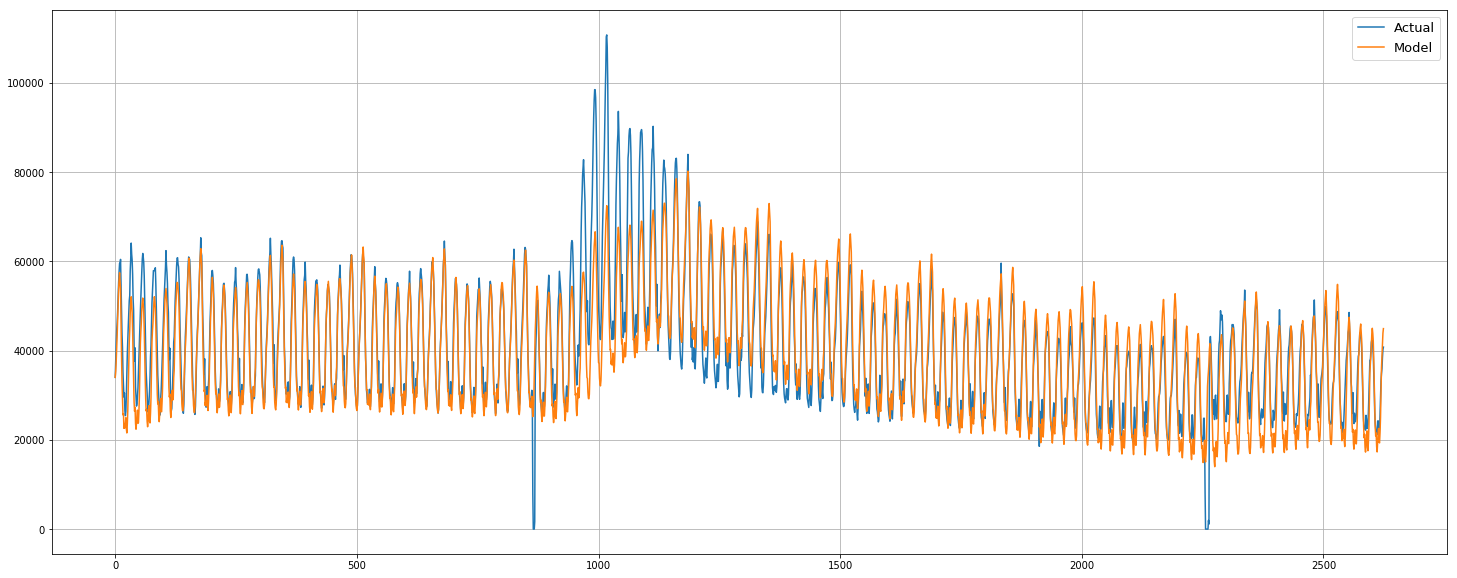

In [33]:
plotHoltWinters()

In [34]:
df_holt = pd.concat([pd.DataFrame(data.values, index=data.index),
                     pd.DataFrame(model.result, index=data.index)], axis=1)
df_holt.columns=['Actual', 'HoltWinters']

In [35]:
plotly_df(df_holt, title='HoltWinters')

In [36]:
def plotHoltWinters():
    Anomalies = np.array([np.NaN]*len(data))
    Anomalies[data.values<model.LowerBond] = data.values[data.values<model.LowerBond]
    #Anomalies[data.values>model.UpperBond] = data.values[data.values>model.UpperBond]
    plt.figure(figsize=(25, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
    plt.plot(model.LowerBond, "r--", alpha=0.5)
    plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, y2=model.LowerBond, alpha=0.5, color = "grey")
    plt.plot(data.values, label = "Actual")
    plt.plot(Anomalies, "o", markersize=10, label = "Anomalies")
    plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

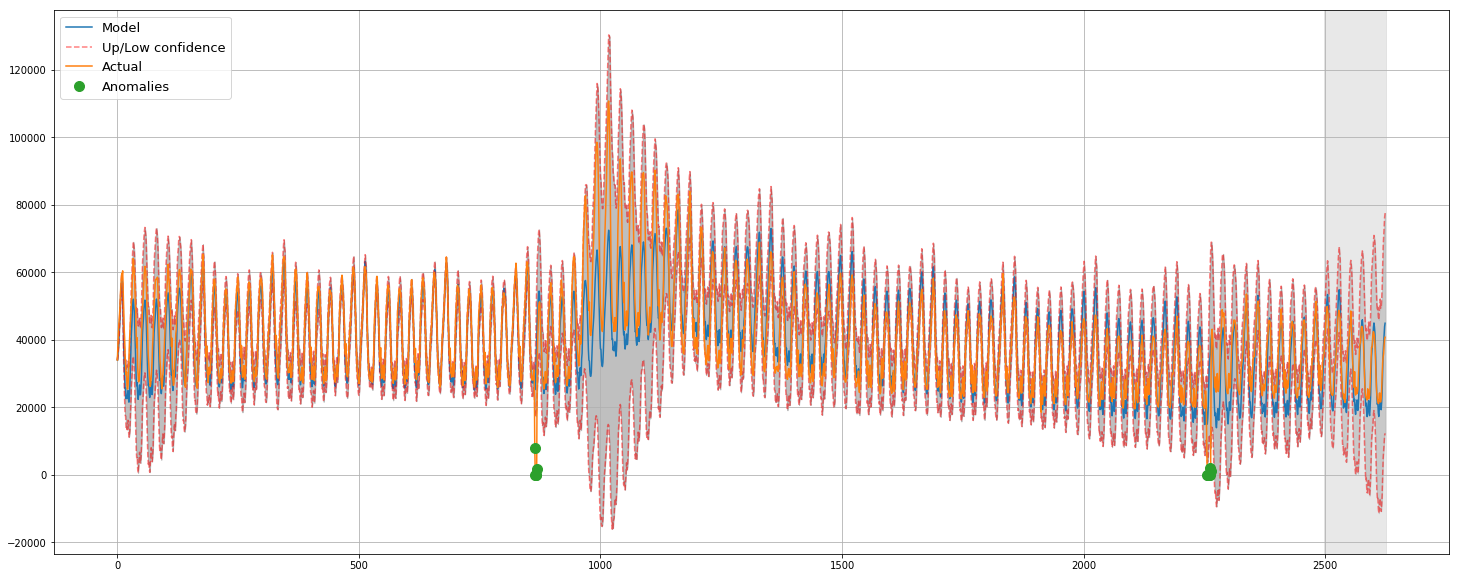

In [37]:
plotHoltWinters()

Судя по графику, модель неплохо описала исходный временной ряд, уловив недельную и дневную сезонность, и даже смогла поймать аномальные снижения, вышедшие за пределы доверительных интервалов. Если посмотреть на смоделированное отклонение, хорошо видно, что модель достаточно резко регирует на значительные изменения в структуре ряда, но при этом быстро возвращает дисперсию к обычным значениям, "забывая" прошлое. Такая особенность позволяет неплохо и без значительных затрат на подготовку-обучение модели настроить систему по детектированию аномалий даже в достаточно шумных рядах.

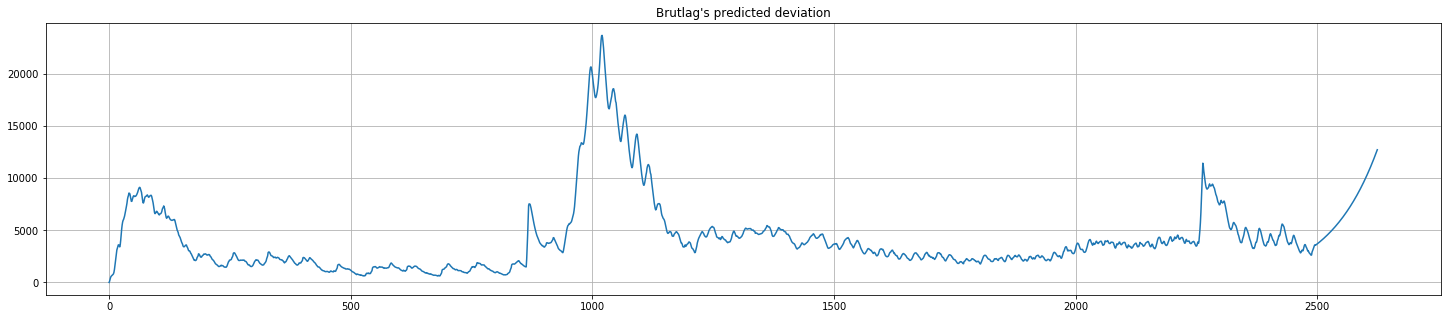

In [38]:
plt.figure(figsize=(25, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

# Линейные (и не только) модели на временных рядах

Снова небольшое лирическое отступление. Часто на работе приходится строить модели, руководствуясь одним основополагающим принципом – быстро, но качественно и без лишних трудозатрат. Поэтому часть моделей могут банально не подойти для "продакшн-решений", так как либо требуют слишком больших затрат по подготовке данных (например, SARIMA, - поговорим о ней позже), либо сложно настраиваются, либо требуют частого переобучения на новых данных (опять SARIMA), поэтому зачастую гораздо проще бывает выделить несколько признаков из имеющегося временного ряда и построить по ним обычную линейную регрессию или навесить решаюший лес. Дешево и сердито.

Возможно, этот подход не является значительно подкрепленным теорией, нарушает различные предпосылки, например, условия Гаусса-Маркова, особенно пункт про некоррелированность ошибок, однако на практике нередко выручает и достаточно активно используется в соревнованиях по машинному обучению.

# Извлечение признаков (Feature exctraction)

Помимо стандартных признаков вроде лагов целевой переменной, много информации содержат в себе дата и время. Про извлечение признаков из них уже здорово описано в одной из [предыдущих статей](https://habrahabr.ru/company/ods/blog/325422/#vremennye-ryady-veb-i-prochee) курса.

Добавлю только про еще один вариант кодирования категориальных признаков – кодирование средним. Если не хочется раздувать датасет множеством дамми-переменных, которые могут привести к потере информации о расстоянии, а в вещественном виде возникают противоречивые результаты а-ля "0 часов < 23 часа", то можно закодировать переменную чуть более интерпретируемыми значениями. Естественный вариант – закодировать средним значением целевой переменной. В нашем случае каждый день недели или час дня можно закодировать сооветствующим средним числом игроков, находившихся в этот день недели или час онлайн. При этом важно следить за тем, чтобы расчет среднего значения производился только в рамках тестового датасета (или в рамках текущего наблюдаемого фолда при кросс-валидации), иначе можно ненароком привнести в модель информацию о будущем.

Итак, какие есть варианты извлечь признаки (dummies-версия). Создадим новый датафрейм и добавим в него час, день недели и выходной в качестве категориальных переменных. Для этого переводим имеющийся в датафрейме индекс в формат `datetime`, и извлекаем из него `hour` и `weekday`.

In [39]:
data = pd.DataFrame(dataset.copy())
data.columns = ['y']
data.index = pd.to_datetime(data.index)

In [40]:
hour_dummy_df = pd.get_dummies(data.index.hour, prefix='hour').set_index(data.index)
weekday_dummy_df = pd.get_dummies(data.index.weekday, prefix='weekday').set_index(data.index)
is_weekend_dummy_df = pd.get_dummies(data.index.weekday.isin([5,6]) * 1, prefix='is_weekend').set_index(data.index)
features_dummy_df = pd.concat([data, hour_dummy_df, weekday_dummy_df, is_weekend_dummy_df], axis=1, join='inner')

In [41]:
pd.set_option('max_columns', 100)

In [42]:
features_dummy_df.head()

y  hour_0  hour_1  hour_2  hour_3  hour_4  hour_5  \
Time                                                                         
2017-01-01 00:00:00  34002       1       0       0       0       0       0   
2017-01-01 01:00:00  37947       0       1       0       0       0       0   
2017-01-01 02:00:00  41517       0       0       1       0       0       0   
2017-01-01 03:00:00  44476       0       0       0       1       0       0   
2017-01-01 04:00:00  46234       0       0       0       0       1       0   

                     hour_6  hour_7  hour_8  hour_9  hour_10  hour_11  \
Time                                                                    
2017-01-01 00:00:00       0       0       0       0        0        0   
2017-01-01 01:00:00       0       0       0       0        0        0   
2017-01-01 02:00:00       0       0       0       0        0        0   
2017-01-01 03:00:00       0       0       0       0        0        0   
2017-01-01 04:00:00       0       0       0       0        0        0   

                     hour_12  hour_13  hour_14  hour_15  hour_16  hour_17  \
Time                                                                        
2017-01-01 00:00:00        0        0        0        0        0        0   
2017-01-01 01:00:00        0        0        0        0        0        0   
2017-01-01 02:00:00        0        0        0        0        0        0   
2017-01-01 03:00:00        0        0        0        0        0        0   
2017-01-01 04:00:00        0        0        0        0        0        0   

                     hour_18  hour_19  hour_20  hour_21  hour_22  hour_23  \
Time                                                                        
2017-01-01 00:00:00        0        0        0        0        0        0   
2017-01-01 01:00:00        0        0        0        0        0        0   
2017-01-01 02:00:00        0        0        0        0        0        0   
2017-01-01 03:00:00        0        0        0        0        0        0   
2017-01-01 04:00:00        0        0        0        0        0        0   

                     weekday_0  weekday_1  weekday_2  weekday_3  weekday_4  \
Time                                                                         
2017-01-01 00:00:00          0          0          0          0          0   
2017-01-01 01:00:00          0          0          0          0          0   
2017-01-01 02:00:00          0          0          0          0          0   
2017-01-01 03:00:00          0          0          0          0          0   
2017-01-01 04:00:00          0          0          0          0          0   

                     weekday_5  weekday_6  is_weekend_0  is_weekend_1  
Time                                                                   
2017-01-01 00:00:00          0          1             0             1  
2017-01-01 01:00:00          0          1             0             1  
2017-01-01 02:00:00          0          1             0             1  
2017-01-01 03:00:00          0          1             0             1  
2017-01-01 04:00:00          0          1             0             1

Можно извлечь напрямую

In [43]:
features_df = data

In [44]:
features_df['hour'] = features_df.index.hour
features_df['weekday'] = features_df.index.weekday
features_df['is_weekend'] = features_df.weekday.isin([5,6])*1
features_df.head()

y  hour  weekday  is_weekend
Time                                                 
2017-01-01 00:00:00  34002     0        6           1
2017-01-01 01:00:00  37947     1        6           1
2017-01-01 02:00:00  41517     2        6           1
2017-01-01 03:00:00  44476     3        6           1
2017-01-01 04:00:00  46234     4        6           1

Как добавить, например, среднее по дням недели

In [45]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

Посмотрим на средние по дням недели

In [46]:
code_mean(data, 'weekday', 'y')

{0: 38730.143229166664,
 1: 38632.828125,
 2: 38128.518229166664,
 3: 39519.035135135135,
 4: 41505.15277777778,
 5: 43717.708333333336,
 6: 43392.14360313316}

Помимо перечисленных преобразований для увеличения числа признаков используют и множество других метрик, например, максимальное/минимальное значение, наблюдавшееся в скользящем по ряду окне, медианы, число пиков, взвешенные дисперсии и многое другое. Автоматически этим занимается уже упоминавшаяся в курсе [библиотека tsfresh](https://github.com/blue-yonder/tsfresh).

Для удобства все преобразования можно записать в одну функцию, которая сразу же будет возвращать разбитые на трейн и тест датасеты и целевые переменные.

In [47]:
def prepare_data(data, lags, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ['y']
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))
    
    # добавляем лаги исходного ряда в качестве признаков
    for ll in lags:
        data['lag_{}'.format(ll)] = data.y.shift(ll)
        
    
    #data.index = data.index.to_datetime()
    data['hour'] = data.index.hour
    data['weekday'] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # считаем средние только по тренировочной части, чтобы избежать лика
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', 'y').get, data.weekday))
    data['hour_average'] = list(map(code_mean(data[:test_index], 'hour', 'y').get, data.hour))

    # выкидываем закодированные средними признаки 
    data.drop(['hour', 'weekday'], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

Обучим на получившихся данных простую линейную регрессию. 

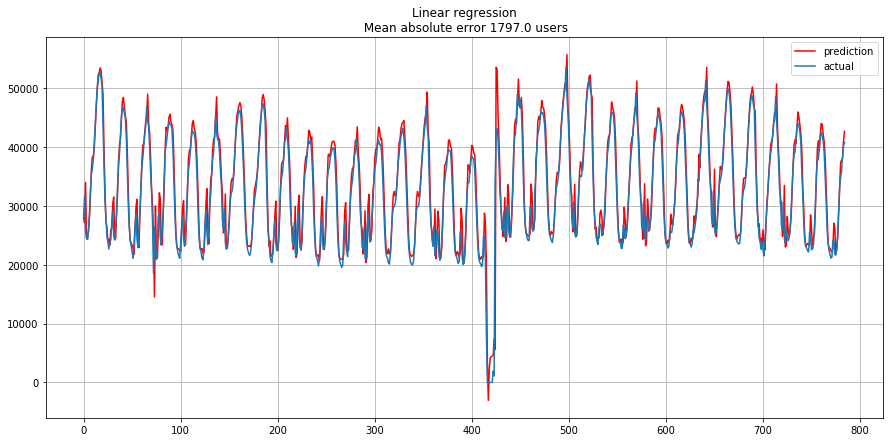

In [48]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepare_data(dataset.Users, lags = [1,2,3], test_size=0.3)
model = LinearRegression(normalize=False)
model.fit(X_train, y_train)
prediction = model.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True)

In [49]:
X_train

lag_1    lag_2    lag_3  is_weekend  weekday_average  hour_average
0     41517.0  37947.0  34002.0           1     47361.657795  44208.467532
1     44476.0  41517.0  37947.0           1     47361.657795  50026.142857
2     46234.0  44476.0  41517.0           1     47361.657795  53812.779221
3     48842.0  46234.0  44476.0           1     47361.657795  56388.610390
4     52245.0  48842.0  46234.0           1     47361.657795  59498.285714
...       ...      ...      ...         ...              ...           ...
1833  48286.0  53031.0  59581.0           1     47773.740157  48084.168831
1834  44252.0  48286.0  53031.0           1     47773.740157  42724.236842
1835  39370.0  44252.0  48286.0           1     47773.740157  37372.223684
1836  36440.0  39370.0  44252.0           1     47773.740157  34212.605263
1837  30674.0  36440.0  39370.0           1     47773.740157  34159.921053

[1838 rows x 6 columns]

In [50]:
y_train

0       44476
1       46234
2       48842
3       52245
4       55245
        ...  
1833    44252
1834    39370
1835    36440
1836    30674
1837    28294
Name: y, Length: 1838, dtype: int64

In [51]:
pd.concat([X_train, y_train], axis=1)

lag_1    lag_2    lag_3  is_weekend  weekday_average  hour_average  \
0     41517.0  37947.0  34002.0           1     47361.657795  44208.467532   
1     44476.0  41517.0  37947.0           1     47361.657795  50026.142857   
2     46234.0  44476.0  41517.0           1     47361.657795  53812.779221   
3     48842.0  46234.0  44476.0           1     47361.657795  56388.610390   
4     52245.0  48842.0  46234.0           1     47361.657795  59498.285714   
...       ...      ...      ...         ...              ...           ...   
1833  48286.0  53031.0  59581.0           1     47773.740157  48084.168831   
1834  44252.0  48286.0  53031.0           1     47773.740157  42724.236842   
1835  39370.0  44252.0  48286.0           1     47773.740157  37372.223684   
1836  36440.0  39370.0  44252.0           1     47773.740157  34212.605263   
1837  30674.0  36440.0  39370.0           1     47773.740157  34159.921053   

          y  
0     44476  
1     46234  
2     48842  
3     52245  
4     55245  
...     ...  
1833  44252  
1834  39370  
1835  36440  
1836  30674  
1837  28294  

[1838 rows x 7 columns]

In [52]:
y_train

0       44476
1       46234
2       48842
3       52245
4       55245
        ...  
1833    44252
1834    39370
1835    36440
1836    30674
1837    28294
Name: y, Length: 1838, dtype: int64

Посмотрим, какие лаги действительно значимые

In [53]:
y_train_series = pd.Series(data=np.array(y_train), index=dataset.Users.index[:len(y_train)])

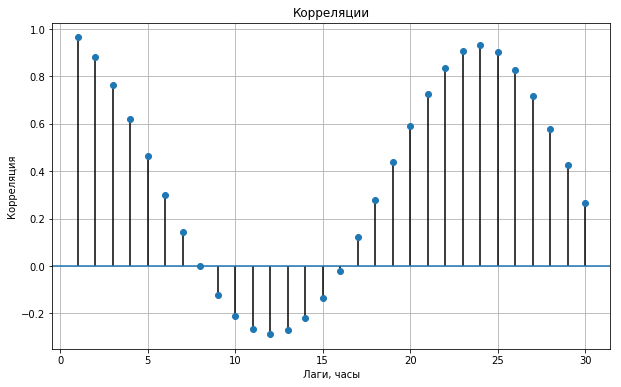

In [54]:
n_lags = 30
corr_list = []
for i_lag in range(1,n_lags+1):
    corr_list.append(np.corrcoef(y_train_series[i_lag:], y_train_series.shift(i_lag)[i_lag:])[0,1])
plt.figure(figsize=(10,6))
plt.vlines(range(1,n_lags+1), [0], corr_list)
plt.axhline()
plt.plot(range(1, n_lags+1), corr_list, 'o')
plt.title('Корреляции')
plt.xlabel('Лаги, часы')   
plt.ylabel('Корреляция')
plt.grid(True)
plt.show()

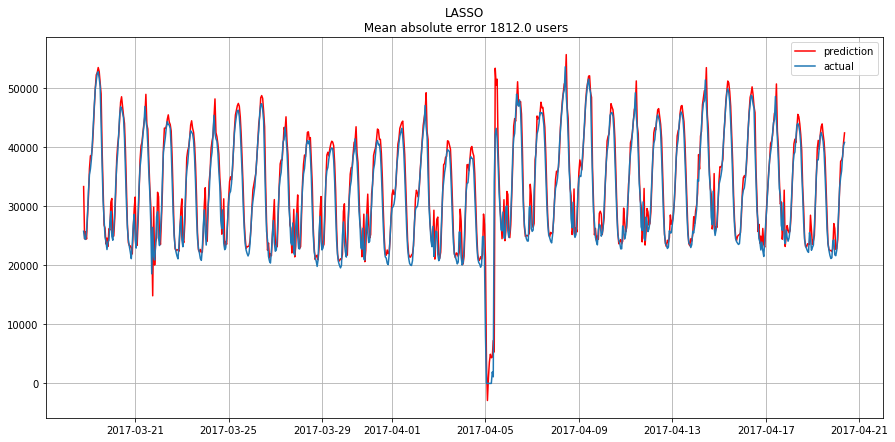

In [55]:
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = prepare_data(dataset.Users, lags = [1,2,3,4,5], test_size=0.3)
lr = Lasso(alpha=1)
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
y_series_values = pd.Series(y_test.values, index=dataset.Users.index[-len(y_test.values):])
prediction_series = pd.Series(prediction, index=dataset.Users.index[-len(y_test.values):])
plt.figure(figsize=(15, 7))
plt.plot(prediction_series, "r", label="prediction")
plt.plot(y_series_values, label="actual")
plt.legend(loc="best")
plt.title("LASSO\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [56]:
def movingMAE(actual, prediction, rolling_window=20):
    mae = np.abs(actual-prediction).rolling(rolling_window).mean().dropna()
    plt.figure(figsize=(17,10))
    plt.plot(mae)
    plt.show()

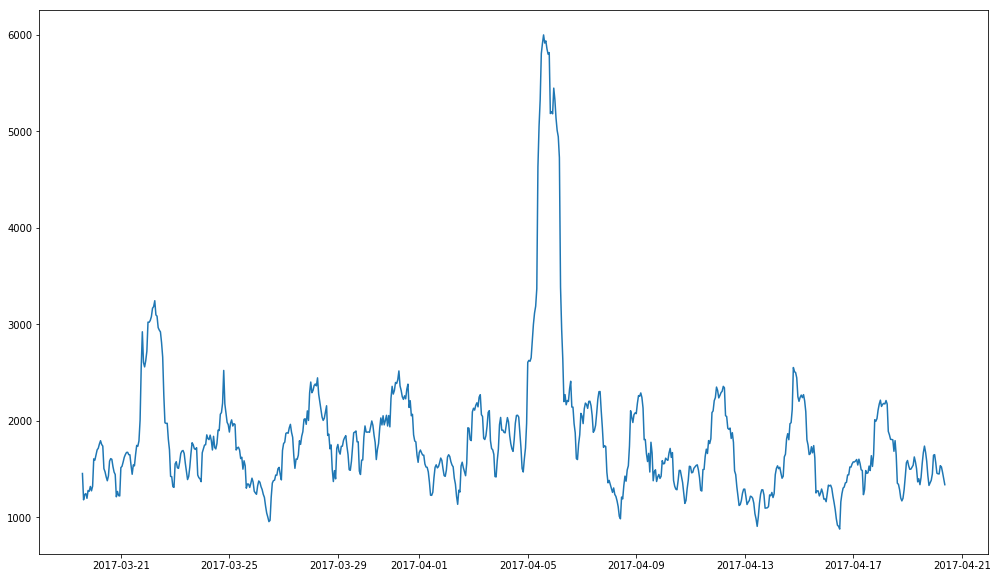

In [57]:
movingMAE(y_series_values, prediction_series)

Получилось достаточно неплохо, даже отбора признаков модель ошибается, в среднем, на 1.8K пользователей в час, и это учитывая огромный выброс в середине тестового ряда.

Возьмем какой-нибудь банкомат (выведем несколько банкоматов вообще, чтобы посмотреть, какие бывают кейсы со спросом). С чем по факту приходится иметь дело.

869273


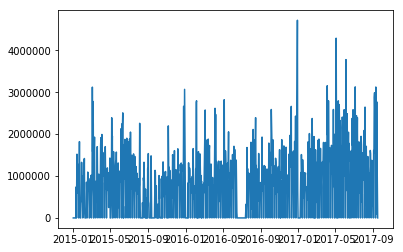

785116


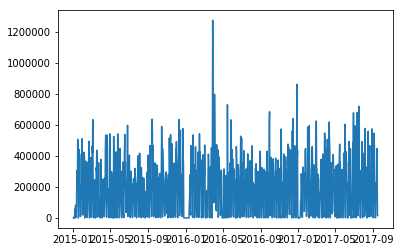

786314


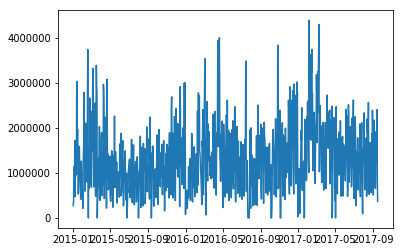

786676


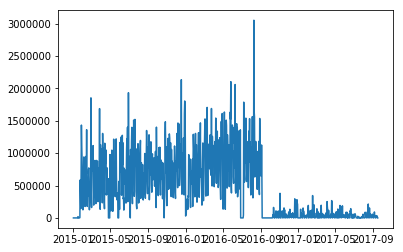

791711


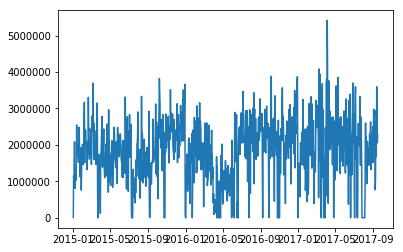

791712


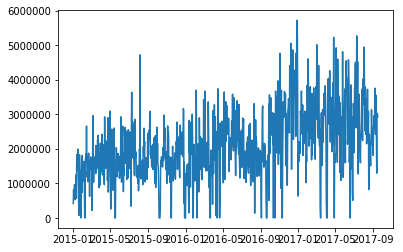

794249


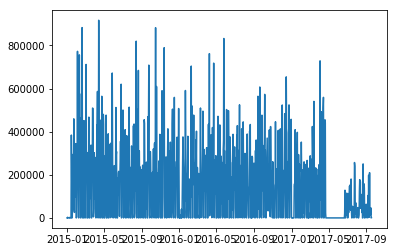

794287


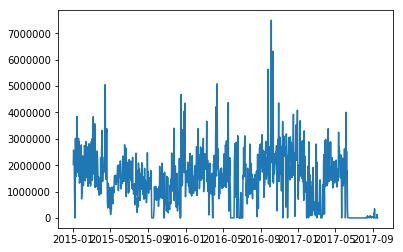

794288


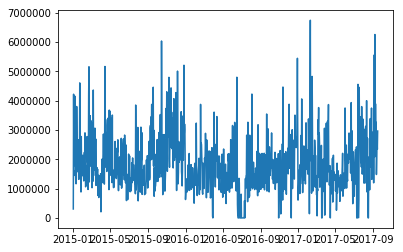

794289


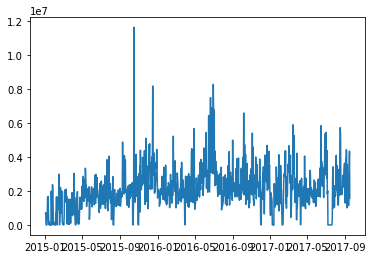

794989


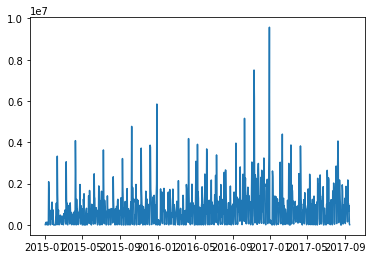

785115


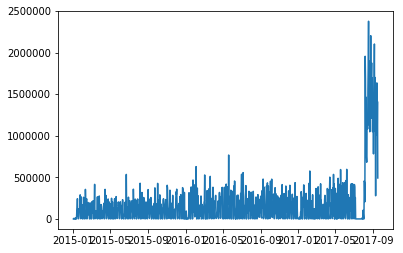

794992


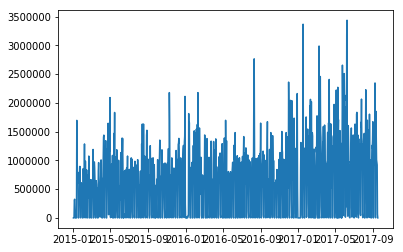

796427


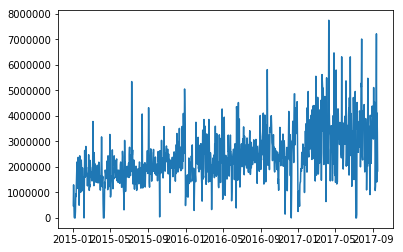

796428


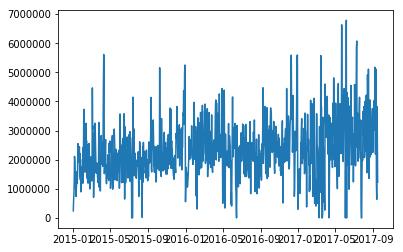

797235


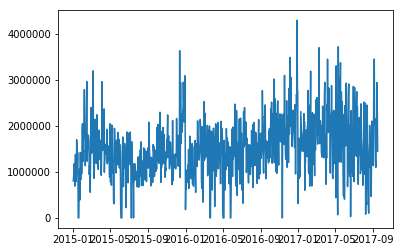

798092


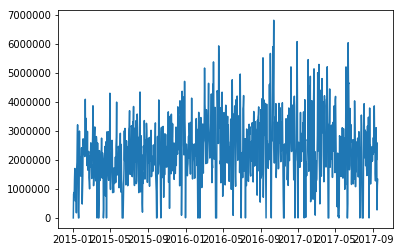

798105


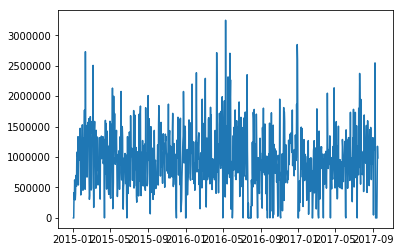

801061


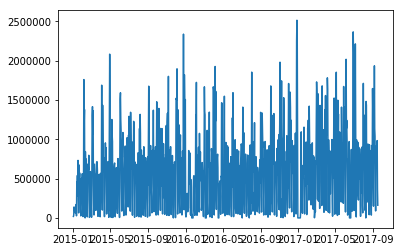

801096


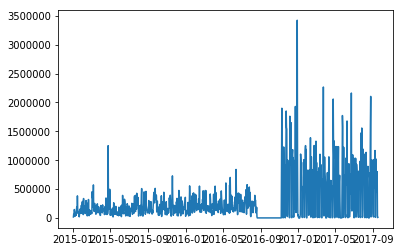

In [58]:
for ida in all_data.ATM_ID.unique()[:20]:
    print(ida)
    plt.plot(all_data[all_data.ATM_ID==ida]['Клиентский расход'])
    plt.show()

In [59]:
timeseries=all_data[all_data.ATM_ID == 869273]['Клиентский расход']

In [60]:
X_train, X_test, y_train, y_test = prepare_data(timeseries, lags = [1,2,3], test_size=0.3)

In [61]:
model = LinearRegression()

In [62]:
model.fit(X_train, y_train)

LinearRegression()

In [63]:
prediction = [(model.predict(X_test)[j] if model.predict(X_test)[j] > 0 else 0) for j in range(len(y_test))]

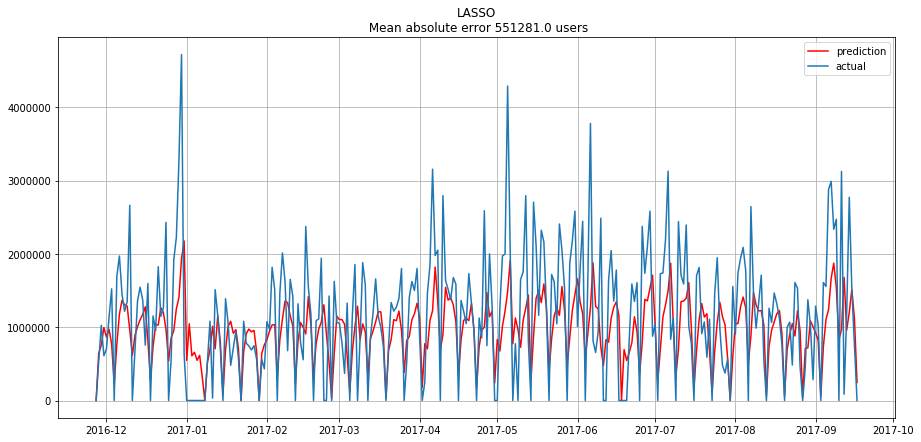

In [64]:
y_series_values = pd.Series(y_test.values, index=timeseries.index[-len(y_test.values):])
prediction_series = pd.Series(prediction, index=timeseries.index[-len(y_test.values):])
plt.figure(figsize=(15, 7))
plt.plot(prediction_series, "r", label="prediction")
plt.plot(y_series_values, label="actual")
plt.legend(loc="best")
plt.title("LASSO\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

In [65]:
timeseries=all_data[all_data.ATM_ID == 786676]['Клиентский расход']
X_train, X_test, y_train, y_test = prepare_data(timeseries, lags = [1,2,3], test_size=0.4)
model = LinearRegression()
model.fit(X_train, y_train)
prediction = [(model.predict(X_test)[j] if model.predict(X_test)[j] > 0 else 0) for j in range(len(y_test))]

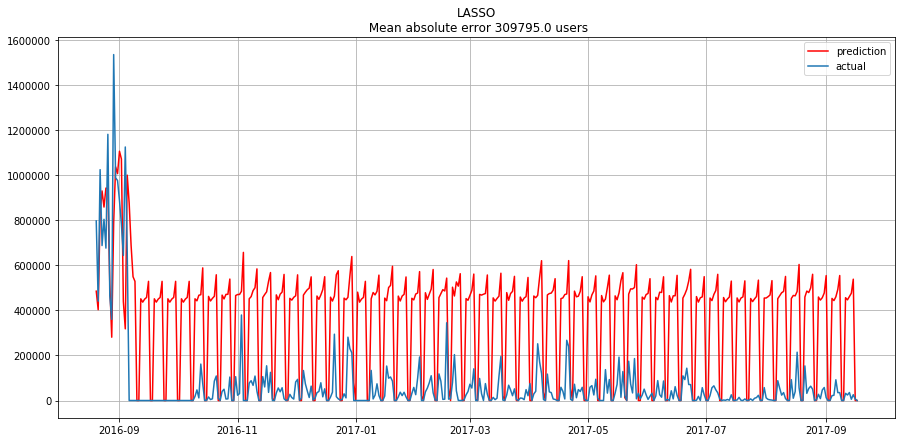

In [66]:
y_series_values = pd.Series(y_test.values, index=timeseries.index[-len(y_test.values):])
prediction_series = pd.Series(prediction, index=timeseries.index[-len(y_test.values):])
plt.figure(figsize=(15, 7))
plt.plot(prediction_series, "r", label="prediction")
plt.plot(y_series_values, label="actual")
plt.legend(loc="best")
plt.title("LASSO\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Тут совсем все плохо как-то

Также можно провести оценку модели на кросс-валидации, тому же принципу, что был использован ранее. Для этого воспользуемся функцией (с небольшими модификациями), предложенной в посте [Pythonic Cross Validation on Time Series](http://francescopochetti.com/pythonic-cross-validation-time-series-pandas-scikit-learn/)

In [67]:
def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
    print('Size train set: {}'.format(X_train.shape))
    
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Size of each fold: {}'.format(k))

    errors = np.zeros(number_folds-1)

    # loop from the first 2 folds to the total number of folds    
    for i in range(2, number_folds + 1):
        print()
        split = float(i-1)/i
        print('Splitting the first ' + str(i) + ' chunks at ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Size of train + test: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))
        
        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]
        
        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]
        
        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    
    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [68]:
performTimeSeriesCV(X_train, y_train, 5, model, mean_absolute_error)

Size train set: (595, 6)
Size of each fold: 119

Splitting the first 2 chunks at 1/2
Size of train + test: (238, 6)

Splitting the first 3 chunks at 2/3
Size of train + test: (357, 6)

Splitting the first 4 chunks at 3/4
Size of train + test: (476, 6)

Splitting the first 5 chunks at 4/5
Size of train + test: (595, 6)


246254.2928396571

Почему бы теперь не попробовать XGBoost
<img src="https://habrastorage.org/files/754/a9a/26e/754a9a26e59648de9fe2487241a27c43.jpg"/>

In [69]:
import xgboost as xgb

def XGB_forecast(data, lags = [1,2,3], test_size=0.15, scale=1.96):
    
    # исходные данные
    X_train, X_test, y_train, y_test = prepare_data(dataset.Users, lags, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)
    
    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000
    
    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())
    
    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])
    
    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]
    
    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)
    
    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()

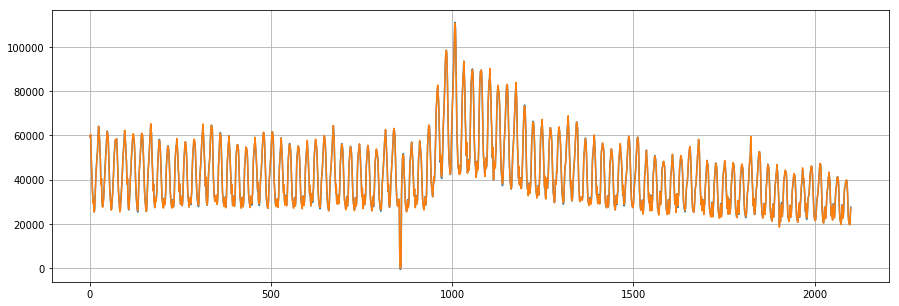

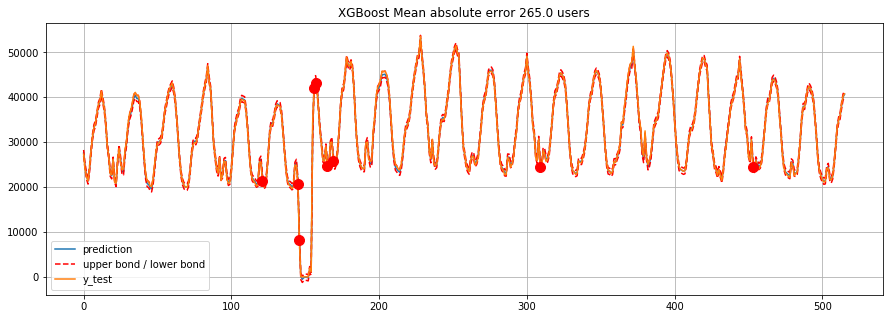

In [70]:
XGB_forecast(dataset, test_size=0.2, lags=range(10))

Итак, всего 265 пользователей в средней абсолютной ошибке, и неплохо пойманные аномалии на тестовом датасете. Конечно, чтобы уменьшить ошибку, еще можно повозиться с параметрами, настроить при необходимости регуляризацию, отобрать признаки, понять, на сколько лагов нужно уходить вглубь истории и т.д. 

# Заключение

Мы познакомились с разными методами и подходами к анализу и прогнозированию временных рядов. К сожалению, или к счастью, серебряной пули для решения такого рода задач пока не появилось. Методы, разработанные в 60-е годы прошлого века, (а некоторые и в начале 19-го), по-прежнему пользуются популярностью наравне с неразобранными в рамках данной статьи LSTM или RNN. Отчасти это связано с тем, что задача прогнозирования, как и любая другая задача, возникающая в процессе работы с данными - во многом творческая и уж точно исследовательская. Несмотря на обилие формальных метрик качества и способов оценки параметров, для каждого временного ряда часто приходится подбирать и пробовать что-то своё. Не последнюю роль играет и баланс между качеством и трудозатратами.

# Полезные ресурсы

- [Онлайн учебник](https://people.duke.edu/~rnau/411home.htm) курса по продвинутому статистическому прогнозированию университета Duke - разобраны всевозможные сглаживания, линейные модели и ARIMA модели 
- Статья [Comparison of ARIMA and Random Forest time series models for prediction of avian influenza H5N1 outbreaks](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-15-276) - одна из немногих, где активно защищается позиция случайного леса в задачах по прогнозированию временных рядов
- Статья [Time Series Analysis (TSA) in Python - Linear Models to GARCH](http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016) семействе моделей ARIMA и их применении для моделирования финансовых показателей (Brian Christopher)